In [3]:
import numpy as np
from numpy import asarray
from numpy import arange
from numpy.random import rand
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn as sns
from func_autograd import *
from sklearn.model_selection import train_test_split
import pandas as pd
import time

#import learned parameters
%store -r gd_gamma_opt
%store -r gd_mom_gamma_opt
%store -r sgd_mom_gamma_opt
%store -r gd_mom_delta_opt
%store -r sgd_mom_delta_opt
%store -r sgd_mom_eta_opt
%store -r sgd_mom_batchsize_opt
%store -r sgd_adam_batchsize_opt

gd_gamma_opt = gd_gamma_opt
gd_mom_gamma_opt = gd_mom_gamma_opt
sgd_mom_gamma_opt = sgd_mom_gamma_opt
gd_mom_delta_opt = gd_mom_delta_opt
sgd_mom_delta_opt = sgd_mom_delta_opt
sgd_mom_eta_opt = sgd_mom_eta_opt
sgd_mom_batchsize_opt = sgd_mom_batchsize_opt
sgd_adam_batchsize_opt = sgd_adam_batchsize_opt

def MSE(y_data, y_model):
	n = np.size(y_model)
	y_data = y_data.reshape(-1,1)
	y_model = y_model.reshape(-1,1)
	return np.sum((y_data - y_model)**2)/n


def generate_data(noise=False, datapoints=200 , FrankesFunction=True):
    # Arrange x and y
    x = np.random.rand(datapoints)
    y = np.random.rand(datapoints)
    # Create meshgrid of x and y
    X, Y = np.meshgrid(x, y)
    
    if FrankesFunction:
        # Calculate the values for Franke function
        z = FrankeFunction(X, Y, noise=noise).flatten()
    else:
        z = TestFunction(X, Y, noise=noise).flatten()

    # Flatten x and y for plotting
    x = X.flatten()
    y = Y.flatten()
    
    return x, y, z

def TestFunction(x, y, noise=False):
    if noise: 
        random_noise = np.random.normal(0, 0.1 , x.shape)
    else: 
        random_noise = 0

    return  x**2 + y**2 + 2*x*y + random_noise

def FrankeFunction(x, y, noise=False):
    if noise: 
        random_noise = np.random.normal(0, 0.1 , x.shape)
    else: 
        random_noise = 0
    
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4 + random_noise

x, y, z = generate_data()
X = create_X(x, y, 6)
X_train, X_test, z_train, z_test = train_test_split(X, z)


# data
lmb = np.logspace(-5, 0, 8)
MSE_val = np.zeros((10, 2, len(lmb)))


In [4]:
for i in range(len(lmb)):

    # Ridge
    beta = np.linalg.inv(X_train.T @ X_train + lmb[i]**np.eye(len(X_train.T))) @ X_train.T @ z_train
    MSE_val[0, 0, i] = MSE(X_train @ beta, z_train)
    MSE_val[0, 1, i] = MSE(X_test @ beta, z_test)

    X_train = X_train[:, 1:3]
    X_test = X_test[:, 1:3]


    # plain gradient descent

    model = GradientDescend(momentum=False, learning_rate=gd_gamma_opt)
    scores = model.fit(X_train, z_train, X_test, z_test)

    pred_train = model.predict(X_train)
    train_score = MSE(pred_train, z_train)
    pred_test = model.predict(X_test)
    test_score = MSE(pred_test, z_test)

    MSE_val[1, 0, i] = train_score
    MSE_val[1, 1, i] = test_score


    # adding momentum

    model = GradientDescend(learning_rate=gd_mom_gamma_opt, delta_momentum=gd_mom_delta_opt)
    scores = model.fit(X_train, z_train, X_test, z_test)

    pred_train = model.predict(X_train)
    train_score = MSE(pred_train, z_train)
    pred_test = model.predict(X_test)
    test_score = MSE(pred_test, z_test)

    MSE_val[2, 0, i] = train_score
    MSE_val[2, 1, i] = test_score


    # minibatch sgd with momentum and learning schedule
    model = GradientDescend(optimizer="sgd", method="gd", learning_rate=sgd_mom_gamma_opt, delta_momentum=sgd_mom_delta_opt,
                            learning_rate_decay_flag=True, learning_rate_decay=sgd_mom_eta_opt, batch_size=sgd_mom_batchsize_opt)
    scores = model.fit(X_train, z_train, X_test, z_test)

    pred_train = model.predict(X_train)
    train_score = MSE(pred_train, z_train)
    pred_test = model.predict(X_test)
    test_score = MSE(pred_test, z_test)

    MSE_val[3, 0, i] = train_score
    MSE_val[3, 1, i] = test_score

    # adagrad 
    # gd without momentum
    model = GradientDescend(momentum=False, method="adagrad")
    scores = model.fit(X_train, z_train, X_test, z_test)

    pred_train = model.predict(X_train)
    MSE_val[4, 0, i] = MSE(pred_train, z_train)
    pred_test = model.predict(X_test)
    MSE_val[4, 1, i] = MSE(pred_test, z_test)

    # gd with momentum
    model = GradientDescend(method="adagrad")
    scores = model.fit(X_train, z_train, X_test, z_test)

    pred_train = model.predict(X_train)
    MSE_val[5, 0, i] = MSE(pred_train, z_train)
    pred_test = model.predict(X_test)
    MSE_val[5, 1, i] = MSE(pred_test, z_test)

    # sgd without momentum
    model = GradientDescend(optimizer="sgd", momentum=False, method="adagrad", batch_size=sgd_adam_batchsize_opt)
    scores = model.fit(X_train, z_train, X_test, z_test)

    pred_train = model.predict(X_train)
    MSE_val[6, 0, i] = MSE(pred_train, z_train)
    pred_test = model.predict(X_test)
    MSE_val[6, 1, i] = MSE(pred_test, z_test)

    # sgd with momentum
    model = GradientDescend(optimizer="sgd", method="adagrad", batch_size=sgd_adam_batchsize_opt)
    scores = model.fit(X_train, z_train, X_test, z_test)

    pred_train = model.predict(X_train)
    MSE_val[7, 0, i] = MSE(pred_train, z_train)
    pred_test = model.predict(X_test)
    MSE_val[7, 1, i] = MSE(pred_test, z_test)

    # rms prop and adam
    # we chose to only evaluate sgd with momentum for this
    model = GradientDescend(optimizer="sgd", method="rmsprop", batch_size=sgd_adam_batchsize_opt)
    scores = model.fit(X_train, z_train, X_test, z_test)

    pred_train = model.predict(X_train)
    MSE_val[8, 0, i] = MSE(pred_train, z_train)
    pred_test = model.predict(X_test)
    MSE_val[8, 1, i] = MSE(pred_test, z_test)

    model = GradientDescend(optimizer="sgd", method="adam", batch_size=sgd_adam_batchsize_opt)
    scores = model.fit(X_train, z_train, X_test, z_test)

    pred_train = model.predict(X_train)
    MSE_val[9, 0, i] = MSE(pred_train, z_train)
    pred_test = model.predict(X_test)
    MSE_val[9, 1, i] = MSE(pred_test, z_test)

ValueError: zero-size array to reduction operation maximum which has no identity

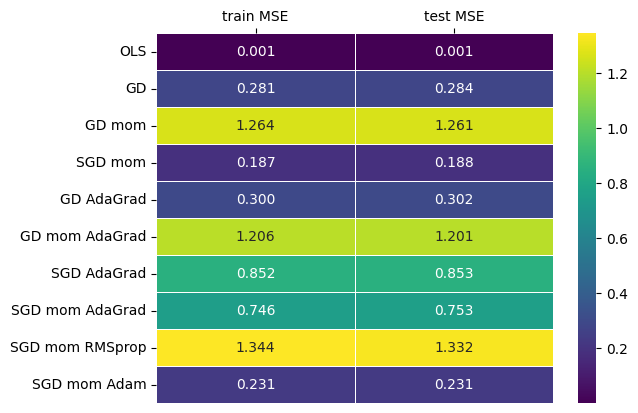

In [ ]:
index = ["OLS", "GD", "GD mom", "SGD mom", "GD AdaGrad", "GD mom AdaGrad", "SGD AdaGrad", "SGD mom AdaGrad", "SGD mom RMSprop", "SGD mom Adam"]
MSE_val = np.around(MSE_val, decimals=3)
df = pd.DataFrame(MSE_val[:,0,:], index=index, columns=lmb)
fig = sns.heatmap(df, cmap="viridis", annot=True, linewidth=.5, fmt=".3f")
fig.set(xlabel="", ylabel="")
fig.xaxis.tick_top()